<a href="https://colab.research.google.com/github/AleemRahil/Robust-End-to-End-E-Commerce-Analytics-Automation-with-LLMs/blob/main/shopify_gbq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Operationalize Ecommerce Data With BigQuery

In this project, I operationalized Shopify data in Google BigQuery. By leveraging BigQuery, we can perform reporting, support various machine learning operations, and build the foundation for generating insights with Large Language Models (LLMs).

In today's data-driven landscape, ETL (Extract, Transform, Load) processes have become somewhat of a commodity, with multiple vendors offering solutions to streamline the process of moving data.

From established platforms like Stitch and Supermetrics to various other vendors, these solutions provide businesses with the tools they need to manage their data workflows efficiently, ensuring that valuable data is accurately captured, transformed, and stored for downstream analysis.

However, while these conventional tools offer reliability and ease of use, they sometimes lack the flexibility needed to accommodate the diverse requirements of different analytical services.

In this notebook, I'll expand upon the work done in the data extracted from Shopify (https://github.com/AleemRahil/Robust-End-to-End-E-Commerce-Analytics-Automation-with-LLMs/blob/main/shopify_data_extraction.ipynb), where we looked into extracting Shopify data using GraphQL.

Here, our focus shifts towards operationalizing Shopify data through Google BigQuery. By leveraging BigQuery, we can not only extract valuable insights from our Shopify data but also harness its potential for machine learning applications.

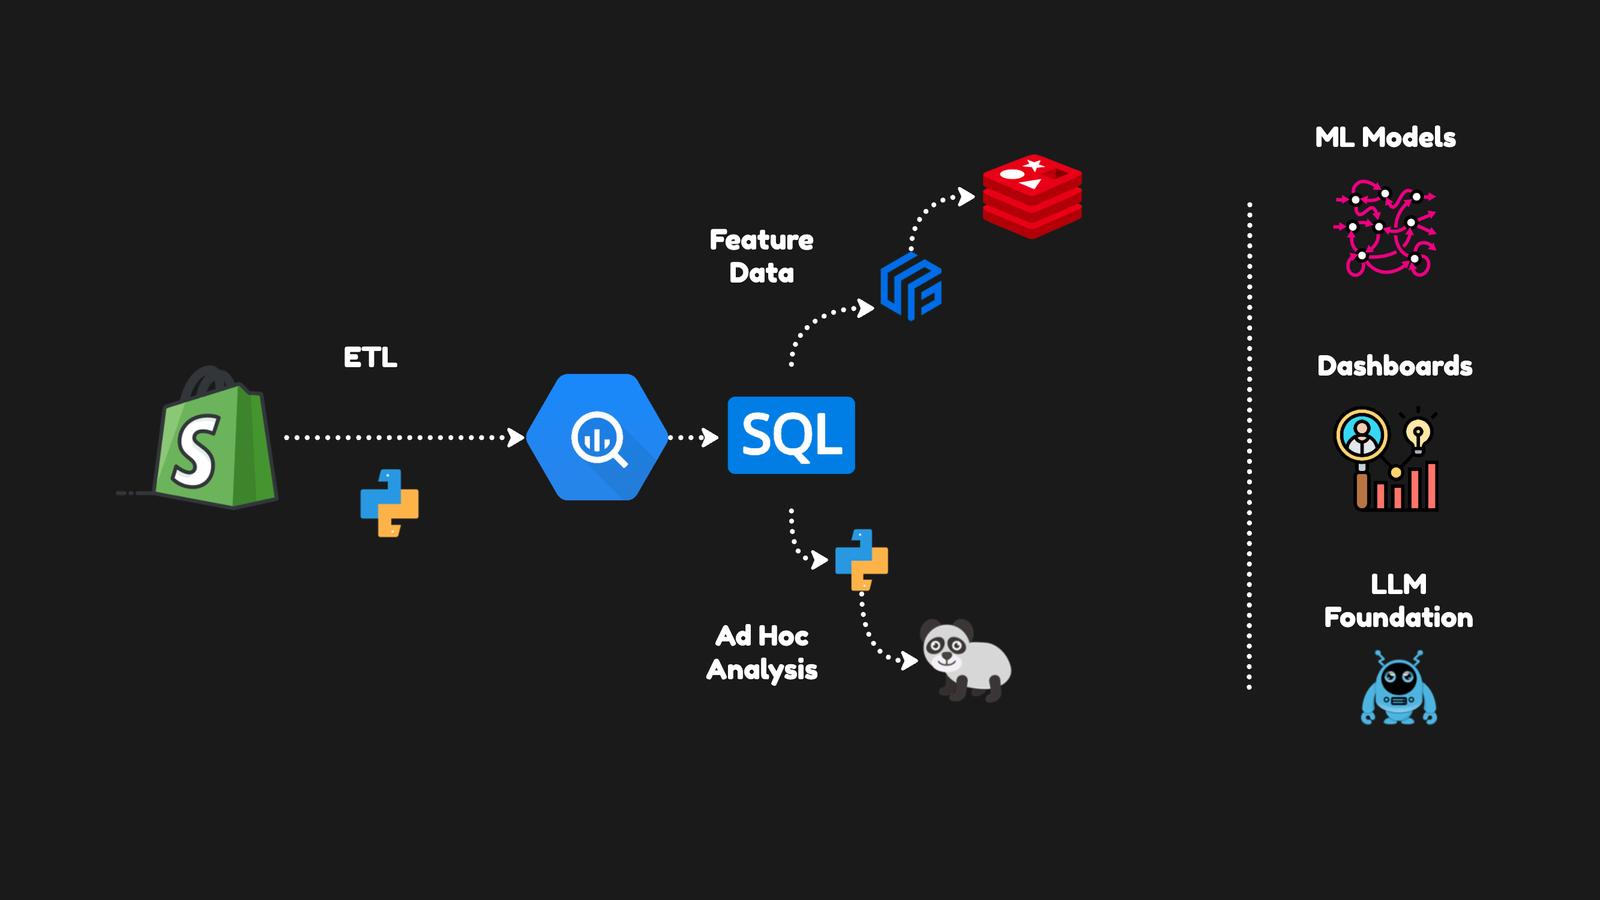

Additionally, we'll explore how this data infrastructure enables us to innovate by creating new data interfaces with Large Language Models (LLMs).

Here's what I'm going to cover:

*   Why you should transfer ecommerce data to a service like BigQuery
*   Core data tables you need to build in BigQuery
*   Extracting and transforming data from Shopify
*   Modeling and loading data to BigQuery
*   Querying data in BigQuery

In [ ]:
!pip install -qU \
  python-dotenv \
  openai \
  ShopifyAPI \
  google-cloud-bigquery

In [ ]:
import shopify
import urllib.request
import pandas as pd
from google.cloud import bigquery

import json
import os
from datetime import datetime

from dotenv import load_dotenv

load_dotenv()

In [ ]:
# Function that initializes the Shopify GraphQL python client
def shopify_client(merchant, token):
    """
    Initialize a Shopify GraphQL client.
    """
    api_session = shopify.Session(merchant, '2023-01', token)
    shopify.ShopifyResource.activate_session(api_session)
    client = shopify.GraphQL()
    return client

In [ ]:
# Set up environment variables for Shopify credentials
merchant= os.getenv('SHOPIFY_MERCHANT')
token = os.getenv('SHOPIFY_TOKEN')

shopify_client = shopify_client(merchant, token)

#Why Transfer Ecommerce Data to BigQuery?
Transferring Ecommerce data to Google BigQuery (GBQ) offers numerous advantages businesses can leverage to enhance their data analytics capabilities. In this section, we will explore why transitioning Ecom data to BigQuery is a strategic move for organizations seeking to optimize their data management processes and unlock actionable insights.

*   De Facto Destination for GA4 Data: Google BigQuery is the default destination for storing and analyzing Google Analytics 4 (GA4) data. As a result, many businesses utilize BigQuery as their primary platform for marketing analytics.
*   Effortless Data Streaming with Pub/Sub: Google Cloud Pub/Sub provides a seamless and efficient way to stream data into BigQuery in real-time.

*   Feature Transformation for ML Models: BigQuery empowers organizations to transform raw ecommerce data into structured features suitable for machine learning (ML) models. Leveraging BigQuery with tools like Feast and Redis, businesses can build online data stores that feed ML models in production.
*   Conversational Querying with LLMsConversational Querying with LLMs: Large Language Models (LLMs) optimized for SQL generation help users interact with BigQuery data conversationally.

*   Cost-Effective and User-Friendly: Google Cloud Platform (GCP), including BigQuery, offers cost-effective and user-friendly solutions tailored to the needs of small and medium-sized businesses. With flexible pricing models and scalable infrastructure, GCP provides organizations with the tools to manage and analyze their ecommerce data efficiently.

#Core Data Tables
Extracting Shopify data follows a consistent process across various objects like customers, products, discounts, and inventory. First, you identify the fields you want to retrieve and then execute a GraphQL query to fetch the data, often wrapped up in a bulk operation.

Next, determine the data types of these fields and decide how you intend to store them in BigQuery, whether as strings, JSON, or other formats. This approach ensures efficiency in handling data extraction, transformation, and load operations.

You can find an overview of various Shopify objects, but for this notebook, we'll narrow our focus to the core objects: customers, orders, and products.

##The customers Table

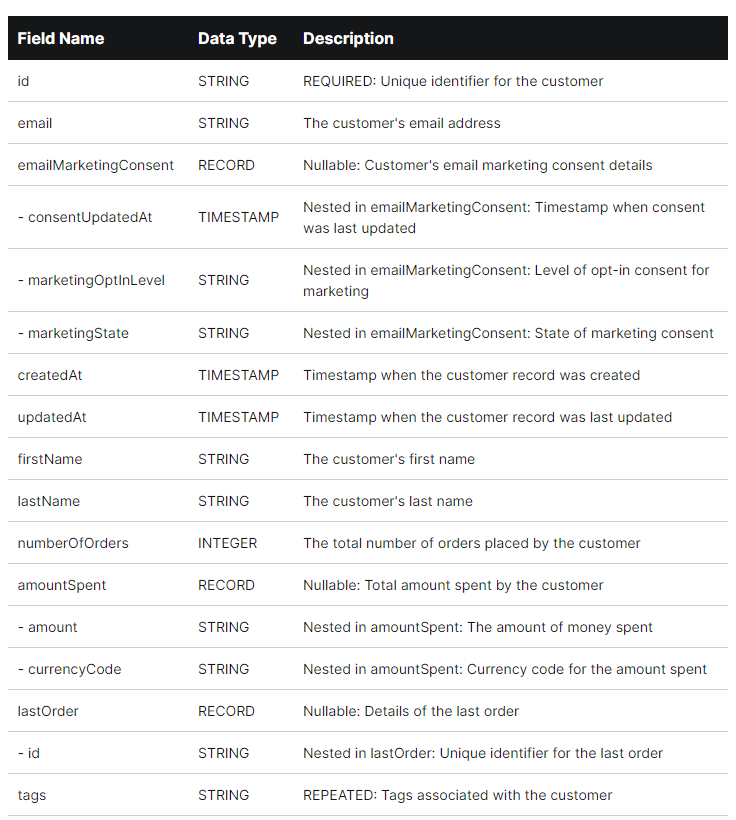

## The orders Table

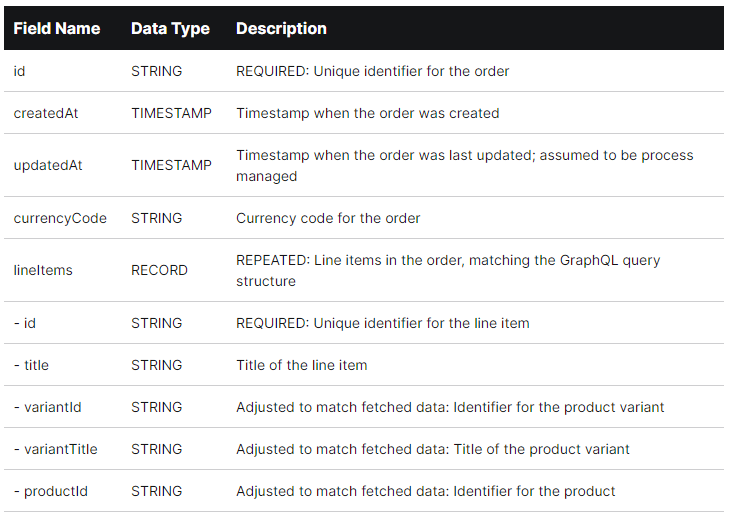

##The products Table

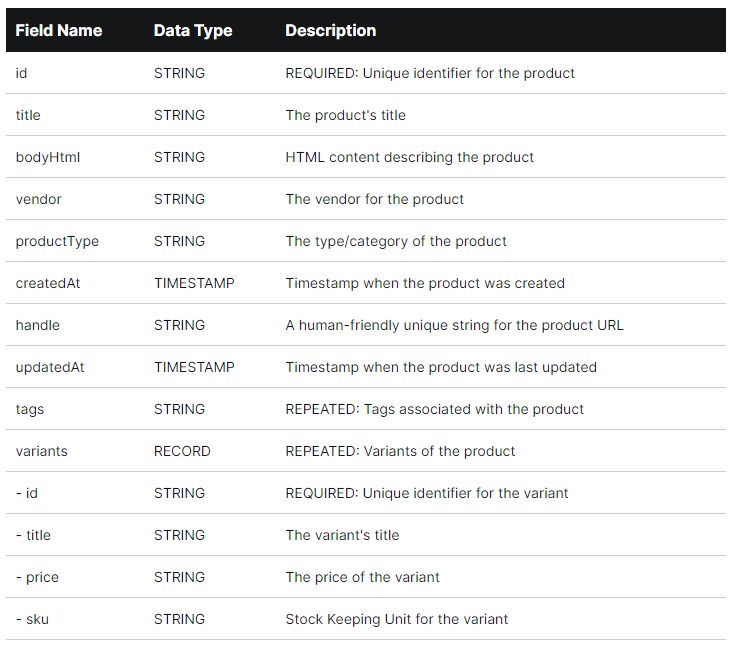

## Shopify Data Extraction

To extract data from Shopify and load it into a BigQuery table, we'll first fetch data using a GraphQL query. In this example, I'll focus on obtaining product data and its variations. The code for extracting all the data is available in the Colab notebook.

We'll fetch the first 10 products, along with details such as ID, name, description, vendor, product type, creation and update timestamps, and tags. Additionally, we'll get details for up to 10 variations of each product, including variant ID, name, price, SKU, and inventory quantity.

Here's the GraphQL query to fetch the first 10 products and their variations:

In [ ]:
# Adjust for the fields and #customers you need https://shopify.dev/docs/api/admin-graphql/2023-10/objects/customer

customers_query = """
query {
  customers(first: 10) {
    edges {
      node {
        id
        email
        emailMarketingConsent {
          consentUpdatedAt
          marketingOptInLevel
          marketingState
        }
        createdAt
        updatedAt
        firstName
        lastName
        numberOfOrders
        amountSpent {
          amount
          currencyCode
        }
        lastOrder {
          id
        }
        tags
      }
    }
  }
}
"""

In [ ]:
# Adjust for the fields and #orders you need https://shopify.dev/docs/api/admin-graphql/2024-01/objects/Order

orders_query = """
query {
  orders(first: 10) {
    edges {
      node {
        id
        createdAt
        currencyCode
        lineItems(first: 5) {
          edges {
            node {
              id
              title
              variant {
                id
                title
                product {
                  id
                }
              }
            }
          }
        }
      }
    }
  }
}

"""

In [ ]:
# Adjust for the fields and #products you need https://shopify.dev/docs/api/admin-graphql/2023-10/objects/product

products_query = """
query {
  products(first: 10) {
    edges {
      node {
        id
        title
        bodyHtml
        vendor
        productType
        createdAt
        handle
        updatedAt
        tags
        variants(first: 10) {
          edges {
            node {
              id
              title
              price
              sku
              inventoryQuantity
            }
          }
        }
      }
    }
  }
}
"""

In [ ]:
# Wrap the base query (customers, orders, products etc) in a bulk operation
def bulk_operation(query):
    q = """
        mutation {
          bulkOperationRunQuery(
            query:""" + json.dumps(query) + """
          ) {
            bulkOperation {
              id
              status
            }
            userErrors {
              field
              message
            }
          }
        }
    """
    return q

# Query that checks the status of the bulk operation
q_bulk_status = """
query bulkStatus($id: ID!) {
  node(id: $id) {
    ... on BulkOperation {
      id
      status
      errorCode
      createdAt
      completedAt
      objectCount
      fileSize
      url
      partialDataUrl
    }
  }
}
"""

# Function the checks the status of the bulk operation using the query above
def bulk_status(client, bulk):
    bulk=json.loads(bulk)
    bulk_id = bulk['data']['bulkOperationRunQuery']['bulkOperation']['id']
    status = json.loads(client.execute(q_bulk_status, {'id': bulk_id}))
    return status

#Transformations

We will extract the data with the fetch_and_prepare_dataframes function, which takes the bulk query status as input. It initializes empty lists and dictionaries for customers, orders, and products. When the bulk query status is completed, it processes the bulk data and populates the lists and dictionaries accordingly. Then, it creates pandas dataframes for customers, orders, and products and updates them based on specific column requirements.

In [ ]:
# Fetch data and process data when shopify bulk query is completed

def fetch_and_prepare_dataframes(bulk_status):
    customers = []
    orders = []
    products = []
    orders_dict = {}
    products_dict = {}

    if bulk_status['data']['node']['status'] == 'COMPLETED':
        url = bulk_status['data']['node']['url']
        with urllib.request.urlopen(url) as mydata:
            for line in mydata:
                line_dict = json.loads(line.decode('utf8'))
                if '__parentId' not in line_dict:
                    if 'Product' in line_dict.get('id', ''):
                        line_dict['variants'] = []  # Initialize variants list for each product
                        products.append(line_dict)
                        products_dict[line_dict['id']] = line_dict
                    elif 'Customer' in line_dict.get('id', ''):
                        customers.append(line_dict)
                    else:
                        line_dict['lineitems'] = []  # Initialize lineitems list for each order
                        orders.append(line_dict)
                        orders_dict[line_dict['id']] = line_dict
                else:
                    parent_id = line_dict['__parentId']
                    if parent_id in orders_dict:
                        orders_dict[parent_id]['lineitems'].append(line_dict)
                    elif parent_id in products_dict:
                        products_dict[parent_id]['variants'].append(line_dict)

    # Convert lists to pandas DataFrames
    customers_df = pd.DataFrame(customers)
    orders_df = pd.DataFrame(orders)
    products_df = pd.DataFrame(products)

    def format_consent(row):
        if pd.notnull(row) and isinstance(row, dict):
            if 'consentUpdatedAt' in row and row['consentUpdatedAt']:
                # Convert consentUpdatedAt to datetime
                row['consentUpdatedAt'] = pd.to_datetime(row['consentUpdatedAt'])
        return row



    # Apply transformations and update dates in one pass per DataFrame
    if not customers_df.empty:
        # Apply the transformation to each row in the emailMarketingConsent column
        customers_df['emailMarketingConsent'] = customers_df['emailMarketingConsent'].apply(format_consent)
        customers_df['numberOfOrders'] = customers_df['numberOfOrders'].astype(int)
        customers_df['createdAt'] = pd.to_datetime(customers_df['createdAt'])
        customers_df['updatedAt'] = datetime.now()
        customers_df['tags'] = customers_df['tags'].apply(lambda x: x if isinstance(x, list) else [])

    if not orders_df.empty:
        orders_df['lineItems'] = orders_df['lineitems'].apply(lambda lineitems: [
            {
                "id": item.get("id"),
                "title": item.get("title"),
                "variantId": item.get("variant", {}).get("id"),
                "variantTitle": item.get("variant", {}).get("title"),
                "productId": item.get("variant", {}).get("product", {}).get("id"),
            }
            for item in lineitems
        ])
        orders_df.drop('lineitems', axis=1, inplace=True)
        orders_df['createdAt'] = pd.to_datetime(orders_df['createdAt'])
        orders_df['updatedAt'] = datetime.now()

    if not products_df.empty:
        products_df['variants'] = products_df['variants'].apply(lambda variants: [
            {
                "id": variant.get("id"),
                "title": variant.get("title"),
                "price": variant.get("price"),
                "sku": variant.get("sku")
            }
            for variant in variants
        ])
        products_df['createdAt'] = pd.to_datetime(products_df['createdAt'])
        products_df['updatedAt'] = datetime.now()
        products_df['tags'] = products_df['tags'].apply(lambda x: x if isinstance(x, list) else [])


    return customers_df, orders_df, products_df


In [ ]:
# Execute the query (here for products)

bulk_query = bulk_operation(products_query)

bulk = shopify_client.execute(bulk_query)


In [ ]:
# Check the status of the bulk operation
status = bulk_status(shopify_client, bulk)

In [ ]:
# When status is complete fetch the data
customers_df, orders_df, products_df = fetch_and_prepare_dataframes(status)

## Loading to BigQuery

Before we can load the data to BigQuery, we need to define the schemas for the tables that will store the customers, orders, and products. These schemas define the structure of the data, including the field names, data types, and properties, such as whether a field is required or optional.

The schemas for customers, orders, and products are defined using the BigQuery API's SchemaField classes:

In [ ]:
# Schema for Customers
customers_schema = [
    bigquery.SchemaField("id", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("email", "STRING"),
    bigquery.SchemaField("emailMarketingConsent", "RECORD", mode="NULLABLE", fields=[
        bigquery.SchemaField("consentUpdatedAt", "TIMESTAMP"),
        bigquery.SchemaField("marketingOptInLevel", "STRING"),
        bigquery.SchemaField("marketingState", "STRING"),
    ]),
    bigquery.SchemaField("createdAt", "TIMESTAMP"),
    bigquery.SchemaField("updatedAt", "TIMESTAMP"),
    bigquery.SchemaField("firstName", "STRING"),
    bigquery.SchemaField("lastName", "STRING"),
    bigquery.SchemaField("numberOfOrders", "INTEGER"),
    bigquery.SchemaField("amountSpent", "RECORD", mode="NULLABLE", fields=[
        bigquery.SchemaField("amount", "STRING"),
        bigquery.SchemaField("currencyCode", "STRING"),
    ]),
    bigquery.SchemaField("lastOrder", "RECORD", mode="NULLABLE", fields=[
        bigquery.SchemaField("id", "STRING"),
    ]),
    bigquery.SchemaField("tags", "STRING", mode="REPEATED"),
]

# Schema for Orders
orders_schema = [
    bigquery.SchemaField("id", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("createdAt", "TIMESTAMP"),
    bigquery.SchemaField("updatedAt", "TIMESTAMP"), # Assuming this is managed on your side as a process timestamp
    bigquery.SchemaField("currencyCode", "STRING"),
    # Define lineItems as a REPEATED RECORD matching the GraphQL query structure
    bigquery.SchemaField("lineItems", "RECORD", mode="REPEATED", fields=[
        bigquery.SchemaField("id", "STRING", mode="REQUIRED"),
        bigquery.SchemaField("title", "STRING"),
        bigquery.SchemaField("variantId", "STRING"), # Adjusted to match fetched data
        bigquery.SchemaField("variantTitle", "STRING"), # Adjusted to match fetched data
        bigquery.SchemaField("productId", "STRING"), # Adjusted to match fetched data
        # Removed fields not present in the GraphQL query response
    ]),
]

# Schema for Products
products_schema = [
    bigquery.SchemaField("id", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("title", "STRING"),
    bigquery.SchemaField("bodyHtml", "STRING"),
    bigquery.SchemaField("vendor", "STRING"),
    bigquery.SchemaField("productType", "STRING"),
    bigquery.SchemaField("createdAt", "TIMESTAMP"),
    bigquery.SchemaField("handle", "STRING"),
    bigquery.SchemaField("updatedAt", "TIMESTAMP"),
    bigquery.SchemaField("tags", "STRING", mode="REPEATED"),
    bigquery.SchemaField("variants", "RECORD", mode="REPEATED", fields=[
        bigquery.SchemaField("id", "STRING", mode="REQUIRED"),
        bigquery.SchemaField("title", "STRING"),
        bigquery.SchemaField("price", "STRING"),
        bigquery.SchemaField("sku", "STRING"),
    ]),
]


For customers, the schema includes fields for the customer's unique identifier, email, marketing consent details, creation and update timestamps, first and last names, number of orders, total amount spent, and tags.

For orders, the schema includes fields for the order's unique identifier, creation and update timestamps, currency code, and a repeated record for line items, which includes details such as the line items' unique identifier, title, variant information, and product identifier.

For products, the schema includes fields for the product's unique identifier, title, body HTML, vendor, product type, creation and update timestamps, handle, and tags, as well as a repeated record for variants, which includes details such as the variant's unique identifier, title, price, and SKU.

These schemas ensure that the data is loaded into BigQuery with the correct structure and validation rules, making it easier to query and analyze later.

Next, I authenticate and connect to the BigQuery API using a service account.

To do this, follow these steps:

Import the necessary libraries: os, google.oauth2, and google.cloud.bigquery.
Set the environment variable for the path to your JSON key file.
Create an service_account.Credentials object using the JSON key file.
Instantiate a BigQuery client using the credentials object and the projectID.

In [ ]:
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./mykey.json"

from google.oauth2 import service_account

# Setup BigQuery client.
service_account_path = './mykey.json'
credentials = service_account.Credentials.from_service_account_file(service_account_path)
gbq_client = bigquery.Client(credentials=credentials, project=credentials.project_id)


The next step is to instantiate the BigQuery client and create tables for customers, orders, and products. Replace 'your_dataset' with your BigQuery dataset name.

In [ ]:
# Replace 'your_dataset' with your BigQuery dataset name
dataset_ref = gbq_client.dataset('shopify_gbq')

# Create Customers Table
customers_table_ref = dataset_ref.table('customers')
customers_table = bigquery.Table(customers_table_ref, schema=customers_schema)
gbq_client.create_table(customers_table)

# Create Orders Table
orders_table_ref = dataset_ref.table('orders')
orders_table = bigquery.Table(orders_table_ref, schema=orders_schema)
gbq_client.create_table(orders_table)

# Create Products Table
products_table_ref = dataset_ref.table('products')
products_table = bigquery.Table(products_table_ref, schema=products_schema)
gbq_client.create_table(products_table)

Now that we have the data in pandas DataFrames and the BigQuery schema is defined, it's time to load it into the corresponding BigQuery tables.

First, set up the necessary variables:

dataset_id: The dataset ID for your BigQuery project and dataset.
table_ids: A dictionary that maps the DataFrame names to their table IDs in BigQuery.
schemas: A dictionary that maps the DataFrame names to their respective schemas.
Next, iterate through the DataFrames and load the data into the corresponding BigQuery tables using the load_table_from_dataframe method:

In [ ]:
dataset_id = 'my_project.your_dataset'
table_ids = {
    'customers': f'{dataset_id}.customers',
    'orders': f'{dataset_id}.orders',
    'products': f'{dataset_id}.products',
}


# Dictionary to map DataFrame names to their respective schemas
schemas = {
    'customers': customers_schema,
    'orders': orders_schema,
    'products': products_schema,
}

# Assuming customers_df, orders_df, and products_df are your pandas DataFrames
for name, df in [('customers', customers_df), ('orders', orders_df), ('products', products_df)]:
    table_id = table_ids[name]
    if not df.empty:
        # Apply the schema explicitly for each DataFrame
        job_config = bigquery.LoadJobConfig(schema=schemas[name])
        job = gbq_client.load_table_from_dataframe(df, table_id, job_config=job_config)
        job.result()  # Wait for the job to complete

        table = gbq_client.get_table(table_id)  # Make an API request to fetch the table info
        print(f"Loaded {table.num_rows} rows and {len(table.schema)} columns to {table_id}")
    else:
        print(f"No data loaded for {name} because the DataFrame is empty.")

This will load the data from the DataFrames into the corresponding BigQuery tables and print the number of rows and columns loaded for each table. You can now perform powerful, large-scale SQL queries on your data using Google Cloud's infrastructure. This allows you to analyze and gain insights from your data more efficiently.

# Querying Data

We can now query the tables in BigQuery using the same client to analyze the ecommerce data. For instance, we can query the dataset to understand customer engagement and spending behavior. By selecting fields such as customer ID, first name, last name, email, number of tags (as a proxy for interests or categories the customer might be associated with), the total amount spent, and the currency of transactions, we can derive insights into the customer base.

In [ ]:
query = """
SELECT
    c.id AS CustomerID,
    c.firstName AS FirstName,
    c.lastName AS LastName,
    c.email,
    ARRAY_LENGTH(c.tags) AS NumberOfTags,
    c.amountSpent.amount AS TotalAmountSpent,
    c.amountSpent.currencyCode AS Currency
FROM
    `rabbitpromotion.shopify_gbq.customers` c
ORDER BY
    CAST(c.amountSpent.amount AS FLOAT64) DESC
"""

df = gbq_client.query(query).to_dataframe()

This example query will order customers based on the total amount spent, casting the amount field from a string to a numeric type for accurate sorting. This process highlights the most valuable customers in terms of monetary contribution to the business. Fetching this data into a Pandas DataFrame makes it easy to visualize spending patterns, segment customers, and tailor marketing or sales strategies to enhance customer engagement.

In the upcoming notebooks, we'll delve deeper into these datasets and learn how to extract valuable insights. We'll explore machine learning techniques and integrate our data with large language models. This will enable us to create interactive data interfaces, opening up new possibilities for analysis.